## Inverse FFD

"Fitting mesh deformation to Free-Form Deformation (namely, inverse FFD)"  

### Requirements

- [numpy], [scipy]  
- [matplotlib]  
- **[libigl]**: Right now, I utilize this library for the following purposes.  
  + **igl.read_obj()**: load obj file  
  + **igl.extract_manifold_patches()**: separate to submeshes  
  + **igl.vertex_triangle_adjacency()**: get the faces that linked to vertex  
- [pyopengltk]: for runtime GUI  

[numpy]:https://numpy.org/
[scipy]:https://www.scipy.org/
[matplotlib]:https://matplotlib.org/
[libigl]:https://libigl.github.io/libigl-python-bindings/
[pyopengltk]:https://github.com/jonwright/pyopengltk

### Formulation

#### 入力データ: 頂点群 $(\mathbf{x}, \mathbf{u})$

UV座標の付与されている，$k$個の頂点を持つ頂点 $(\mathbf{x}, \mathbf{u})_k$  

- XY空間での座標 $\mathbf{x}_k = (x_k,y_k) \in \mathcal{X} $ と
- UV空間での座標 $\mathbf{u}_k = (u_k,v_k) \in \mathcal{U} $ を持っている．

#### 目標出力: 制御点群 $\mathrm{P}$

制御点 $B_{ij} \in \mathcal{U}$ に対応する点 $P_{ij} \in \mathcal{X}$  


In [1]:
## load mesh data with libigl
import numpy as np
import igl

## filediaglog, GL window
import tkinter
import tkinter.filedialog

## load XY-UV mesh
filename = 'data/4.obj'

if True:
    root=tkinter.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)

    fTyp=[('mesh file','*.obj')]
    filename=tkinter.filedialog.askopenfilename(filetypes=fTyp, initialdir='./data', title='Open mesh file')
    root.destroy() ## [CAUTION]

x_full, u_full, _, tri_full, _, _ = igl.read_obj(filename)
x_full = x_full[:,:2] ## reduce vertex dimension: 3D -> 2D

In [2]:
selected = 3 ## [TEMPORARY]

## separate mesh
tri_subs = igl.extract_manifold_patches(tri_full)

## compute vertex to face correspondence in advance
v2f = igl.vertex_triangle_adjacency(tri_full, len(x_full))

<IPython.core.display.Javascript object>


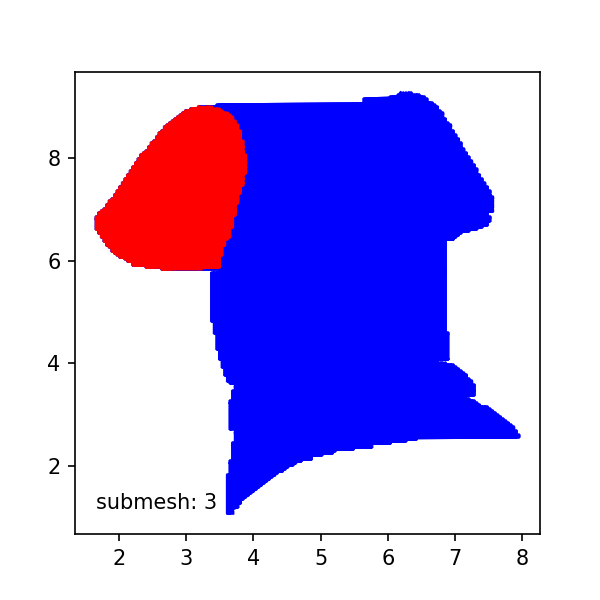

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax0 = plt.subplots(1, 1, figsize=(4,4))

line, = ax0.plot(x_full[:,0], x_full[:,1], c='b', picker=True, pickradius=1)
text = ax0.text(np.min(x_full[:,0]), np.min(x_full[:,1]), "submesh: ", va="bottom", ha="left")

############################################################
## select submesh
############################################################
if True:
    def onpick(event):
        global selected

        if event.artist!=line: return True
        if not len(event.ind): return True

        ax0.plot(x_full[:,0], x_full[:,1], c='b')

        ## get the clicked point
        thisline = event.artist
        xdata = thisline.get_xdata()
        ydata = thisline.get_ydata()
        ind = event.ind

        ## get the submesh id
        selected = tri_subs[1][v2f[0][v2f[1][ind[0]]]]
        text.set_text('submesh: {0}'.format(selected)) ## show as text

        ## visualize the clicked submesh
        tri_sub  = tri_full[tri_subs[1]==selected]
        vidx_sub = np.unique(tri_sub.reshape(-1))
        x = x_full[vidx_sub]
        ax0.plot(x[:,0], x[:,1], c='r')

        return True
    
    fig.canvas.mpl_connect('pick_event', onpick)
    
else:
    text.set_text('submesh: {0}'.format(selected)) ## show as text

    ## visualize the default submesh
    tri_sub  = tri_full[tri_subs[1]==selected]
    vidx_sub = np.unique(tri_sub.reshape(-1))
    x = x_full[vidx_sub]
    ax0.plot(x[:,0], x[:,1], c='r')
    
plt.show()

In [4]:
## select the specific index from user-clicking point
tri_sub = tri_full[tri_subs[1]==selected]

## separate submesh from full mesh
vidx_sub = np.unique(tri_sub.reshape(-1))
x = x_full[vidx_sub]
u = u_full[vidx_sub]

## convert vertex indices for submesh
N = x.shape[0]
vidx = np.arange(0, x.shape[0])

vidx_full_to_sub = {}
for a,b in zip(vidx_sub, vidx):
    vidx_full_to_sub[a] = b

tri = [np.array([vidx_full_to_sub[v0],
                 vidx_full_to_sub[v1],
                 vidx_full_to_sub[v2]])
       for v0, v1, v2 in tri_sub]

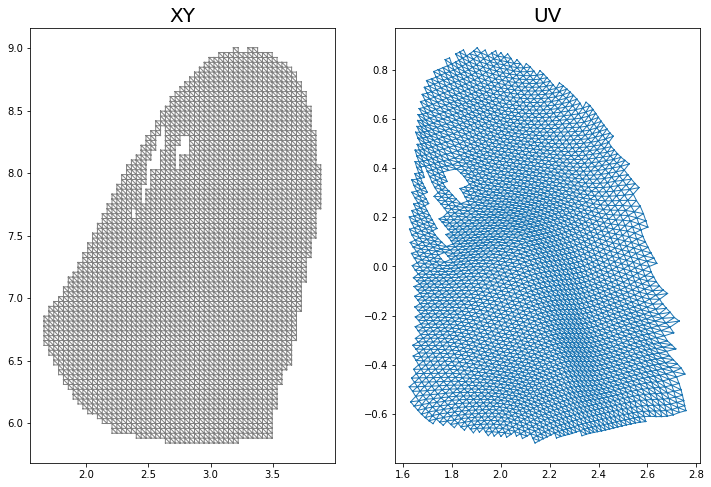

In [5]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

## XY-space (as gray)
ax1.set_title('XY').set_fontsize(20)
ax1.triplot(x[:,0], x[:,1], tri, linewidth=1, c='gray')

if False:
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

## UV-space (as blue)
ax2.set_title('UV').set_fontsize(20)
ax2.triplot(u[:,0], u[:,1], tri, linewidth=1)

if False:
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

plt.show()

### Procedure

#### 1. Initialization: グリッド点 $\mathrm{B}$  

1. UV 空間での bounding box を計算する  
2. U/V 各軸に対して subdivision を行うする  
3. 成す頂点がグリッドの $B_{ij}$ となる  


In [6]:
from datetime import datetime

start = datetime.now()

## compute bounding box
u_min, u_max = np.min(u[:,0]), np.max(u[:,0])
v_min, v_max = np.min(u[:,1]), np.max(u[:,1])

## small spacing for embedding vertices
eps = 2e-2

u_min = u_min - eps
u_max = u_max + eps
v_min = v_min - eps
v_max = v_max + eps

########################################
## compute visualization range
## suppose: vertical > horizontal
########################################
percentile = 0.05
aspect = (u_max-u_min) / (v_max-v_min)

## uv
eps = percentile * (v_max-v_min)
v_min_vis = v_min - eps
v_max_vis = v_max + eps
u_min_vis = (u_max+u_min)*0.5 - (v_max_vis-v_min_vis)*0.5
u_max_vis = (u_max+u_min)*0.5 + (v_max_vis-v_min_vis)*0.5

if aspect > 1.0:
    eps = percentile * (u_max-u_min)
    u_min_vis = u_min - eps
    u_max_vis = u_max + eps
    v_min_vis = (v_max+v_min)*0.5 - (u_max_vis-u_min_vis)*0.5
    v_max_vis = (v_max+v_min)*0.5 + (u_max_vis-u_min_vis)*0.5

end = datetime.now()

print("elapsed time: {0} [sec]".format( (end-start).total_seconds() ))
    
print(u_min, v_min, u_max, v_max)

elapsed time: 0.0 [sec]
1.60583 -0.7389 2.77779 0.90979


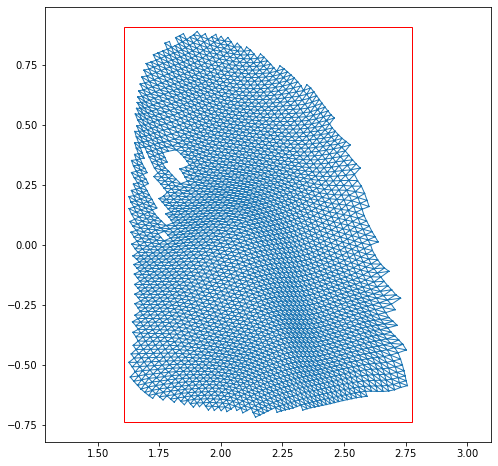

In [7]:
## visualize bounding box
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim([u_min_vis, u_max_vis])
ax.set_ylim([v_min_vis, v_max_vis])
ax.triplot(u[:,0], u[:,1], tri, linewidth=1.0)

if False:
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

ax.add_patch(Rectangle((u_min, v_min), u_max-u_min, v_max-v_min, edgecolor='red', fill=False))

plt.show()

In [8]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact

B_i = np.linspace(u_min, u_max, num=6)
B_j = np.linspace(v_min, v_max, num=8)

B_ix, B_jy = np.meshgrid(B_i, B_j)

def update(subdiv_u, subdiv_v):
    global B_i, B_j, B_ix, B_jy
    
    ## subdivide bounding box
    B_i = np.linspace(u_min, u_max, num=subdiv_u)
    B_j = np.linspace(v_min, v_max, num=subdiv_v)

    B_ix, B_jy = np.meshgrid(B_i, B_j)
    
    ## visualize bounding box
    from matplotlib.patches import Rectangle

    fig, ax = plt.subplots(figsize=(8,8))

    ax.set_xlim([u_min_vis, u_max_vis])
    ax.set_ylim([v_min_vis, v_max_vis])

    ax.triplot(u[:,0], u[:,1], tri, linewidth=1.0)

    ## grid points
    ax.plot(B_ix, B_jy, 'o')

    ## draw lines between grid points
    for Bx in B_i:
        plt.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
    for By in B_j:
        plt.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

    plt.draw()

interact(update,
         subdiv_u = widgets.IntSlider(value=6, min=4, max=10),
         subdiv_v = widgets.IntSlider(value=8, min=4, max=14)
);

interactive(children=(IntSlider(value=6, description='subdiv_u', max=10, min=4), IntSlider(value=8, descriptio…

In [9]:
## get the grid points B_{ij}
B_ij = np.dstack((B_ix, B_jy)).reshape(-1,2)

## revert u/v _ min/max for FFD
u_min, u_max = np.min(u[:,0]), np.max(u[:,0])
v_min, v_max = np.min(u[:,1]), np.max(u[:,1])

#### 2. Definition of cost function $\mathcal{O}$

$\mathcal{O} = \sum_k{ |\mathbf{x}_k - X(\mathbf{u}_k, \mathrm{P})|^2 } $
where
$X(\mathbf{u}, \mathrm{P}) = \sum_{ij}{ {B}_{ij}(\mathbf{u}) \cdot {P}_{ij} }$  

現在，$ {B}_{ij}(\mathbf{u})$ はその$\mathbf{u}$を囲っている4つの制御点までの補間における単純重みとしている．  

![Linear interpolation](LinearInterpolation.svg)


#### 3. Construction of sparse matrix

ここで，疎行列ソルバーを用いて最小二乗法を解く方法について触れておく．  

- $\mathbf{x}$: 定数項として働く, $({k},{2})$, 既知  
- $\mathrm{P}$: 2次元のグリッド交差点数 $({i}\times{j},{2})$, **<mark>未知</mark>**  
- $B_{ij}(\mathbf{u})$: 2次元のグリッド交差点とUV座標からなる疎行列, $({k},{{i}\times{j}})$  

$$ \begin{pmatrix}
    \mathbf{x}_1 \\
    \mathbf{x}_2 \\
    \vdots \\
    \mathbf{x}_k \\
  \end{pmatrix}
- \begin{bmatrix} B_{ij}(\mathbf{u}) \end{bmatrix}
  \begin{pmatrix} 
    P_{11} \\
    P_{12} \\
    \vdots \\
    P_{ij} \\
  \end{pmatrix} $$
  
行列$\mathrm{B}$の成分$B_{ij}(\mathbf{u})$は，グリッド内であるかを判定し，各制御点までの線形補間の値としているため，行列$B_{ij}(\mathbf{u})$には行辺り４つの成分しか存在しない．  
$k$行目に注目してみれば容易に検証可能である:  

$$ \begin{pmatrix} \vdots \\ \mathbf{x}_k \\ \vdots \end{pmatrix}
- \begin{bmatrix}
    {} &\vdots & \vdots & {} & \vdots & \vdots & {} \\
    \cdots & {B}_{i,j}(\mathbf{u}_k) & {B}_{i+1,j}(\mathbf{u}_k ) &
    \cdots & {B}_{i,j+1}(\mathbf{u}_k) & {B}_{i+1,j+1}(\mathbf{u}_k) & \cdots \\
    {} &\vdots & \vdots & {} & \vdots & \vdots & {} \\
  \end{bmatrix}
  \begin{pmatrix} \vdots \\ P_{i,j} \\ P_{i+1,j} \\ \vdots \\ P_{i,j+1} \\ P_{i+1,j+1} \\ \vdots \end{pmatrix}
$$


しかし，上記の式だけだと，頂点が少ないか，全く代入されない格子点においての誤差を解決できない問題が起こり得る．  
そのような問題を防ぐために，格子の縦横方向の傾向性を Regularization term として取り入れる:  

$$ \begin{pmatrix} \vdots \\ 0 \\ \vdots \\ 0 \\ \vdots \end{pmatrix}
- \lambda
  \begin{bmatrix}
    \cdots & \cdot & \cdots & {1} & {-2} & {1} & \cdots & \cdot & \cdots \\
    {} & \vdots & {} & \vdots & \vdots & \vdots & {} & \vdots & {} \\
    \cdots & {1} & \cdots & \cdot & {-2} & \cdot & \cdots & {1} & \cdots \\
  \end{bmatrix}
  \begin{pmatrix}
    \vdots \\ P_{i-1,j} \\ \vdots \\ P_{i,j-1} \\ P_{i,j} \\ P_{i,j+1} \\ \vdots \\ P_{i+1,j} \\ \vdots
  \end{pmatrix}
$$

この両者を取り入れて，自乗最小和問題を立てると:

$$
= \begin{pmatrix} \mathbf{x} \\ \hline \mathbf{0} \end{pmatrix}
- \begin{bmatrix} {B_{ij}}(\mathbf{u}) \\ \hline \lambda L \end{bmatrix}
  {\mathrm{P}}
$$

ここで，$L$は各格子点におけるラプラシアンであり，$\lambda$ は頂点によって決まる格子点座標との折り合い率である．

最後に，通常の最小二乗法のソルバーに落とし込むために，２次元の列部分を１次元化に落とす:  

$$ \begin{pmatrix} \vdots \\ x_k \\ y_k \\ \vdots \\ \hline 
                   \vdots \\ {0} \\ {0} \\ \vdots \\ {0} \\ {0} \\ \vdots
   \end{pmatrix}
- \begin{bmatrix}
    {} & {} & {} & {} & {} & {} & {} & \vdots & \vdots & \vdots & \vdots & {} & {} & {} & {} & {} & {} \\
    {} & {} & {} & {} & {} & {} & \cdots & {\small w_i w_j}  & \cdot & {\small w_{i+1} w_j} & \cdot & \cdots & {\small w_i w_{j+1}} & \cdot & {\small w_{i+1} w_{j+1}} & \cdot & \cdots \\
    {} & {} & {} & {} & {} & {} & \cdots & \cdot & {\small w_i w_j} & \cdot & {\small w_{i+1} w_j} & \cdots & \cdot & {\small w_i w_{j+1}} & \cdot & {\small w_{i+1} w_{j+1}} & \cdots \\
    {} & {} & {} & {} & {} & {} & {} & \vdots & \vdots & \vdots & \vdots & {} & {} & {} & {} & {} & {} \\ \hline
    \ddots & {} & {} & {} & {} & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & {} & {} & {} & {} & {} & {} \\
    \cdots & & \cdot & \cdot & \cdots & {\lambda} & \cdot & {-2\lambda} & \cdot & {\lambda} & \cdot & \cdots & \cdot & \cdot & \cdot & \cdot & \cdots \\
    \cdots & & \cdot & \cdot & \cdots & \cdot & {\lambda} & \cdot & {-2\lambda} & \cdot & {\lambda} & \cdots & \cdot & \cdot & \cdot & \cdot & \cdots \\
    {} & {} & {} & {} & {} & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & {} & {} & {} & {} & {} & {} \\
    \cdots & & {\lambda} & \cdot & \cdots & \cdot & \cdot & {-2\lambda} & \cdot & \cdot & \cdot & \cdots & {\lambda} & \cdot & \cdot & \cdot & \cdots \\
    \cdots & & \cdot & {\lambda} & \cdots & \cdot & \cdot & \cdot & {-2\lambda} & \cdot & \cdot & \cdots & \cdot & {\lambda} & \cdot & \cdot & \cdots \\
    {} & {} & {} & {} & {} & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & {} & {} & {} & {} & {} & \ddots \\
  \end{bmatrix}
  \begin{pmatrix}
    \vdots \\ P_{i,j-1}^x \\ P_{i,j-1}^y \\ \vdots \\ P_{i-1,j}^x \\ P_{i-1,j}^y
    \\ P_{i,j}^x \\ P_{i,j}^y \\ P_{i+1,j}^x \\ P_{i+1,j}^y \\
    \vdots \\ P_{i,j+1}^x \\ P_{i,j+1}^y \\ P_{i+1,j+1}^x \\ P_{i+1,j+1}^y \\ \vdots
  \end{pmatrix}
$$

$$
= \tilde{\mathbf{x}} - \begin{bmatrix} \tilde{B_{ij}}(\mathbf{u}) \end{bmatrix} \tilde{\mathrm{P}}
$$

まとめると，  

- $\tilde{\mathbf{x}}$: 定数項として働く行ベクトル $ \Big( { \big[ k + (i-2)\cdot{j} + i\cdot(j-2) \big] }\times{2},1 \Big)$  
- $\tilde{\mathrm{B}}$: 2次元のグリッド交差点とUV座標からなる疎行列, $ \Big({ \big[k + (i-2)\cdot{j} + i\cdot(j-2) \big] }\times{2}, \big[{i}\times{j}\big]\times{2} \Big)$  
- $\tilde{\mathrm{P}}$: 未知数の，2次元のグリッド交差点の座標を表す行ベクトル $\Big( \big[{i}\times{j}\big]\times{2}, 1 \Big)$  


In [10]:
## construct sparse matrix
from scipy.sparse import dok_matrix
from datetime import datetime

start = datetime.now()

## allocate sparse matrix with additional rows for grid constraints
i = B_i.shape[0]
j = B_j.shape[0]
rows = 2*(x.shape[0] + (i-2)*j + i*(j-2) )
B_tilde = dok_matrix((rows, i*j*2), dtype=np.float32)

def ForEachUV(k, u_k, v_k):
    
    for i in range(len(B_i)-1):
        if (B_i[i] <= u_k and u_k <= B_i[i+1]):
            break
    
    for j in range(len(B_j)-1):
        if (B_j[j] <= v_k and v_k <= B_j[j+1]):
            break
    
    w_i = (B_i[i+1]-u_k) / (B_i[i+1]-B_i[i])
    w_j = (B_j[j+1]-v_k) / (B_j[j+1]-B_j[j])
    
    #print("{0},\t{1} \t-> ({2},{3}), weight = ({4},{5})".format(u_k, v_k, i, j, w_i, w_j))
    
    ## assign each elements into sparse matrix
    B_row = 2 * k

    B_col_i0j0 = 2 * ((i+0) + (j+0)*len(B_i) )
    B_col_i1j0 = 2 * ((i+1) + (j+0)*len(B_i) )
    B_col_i0j1 = 2 * ((i+0) + (j+1)*len(B_i) )
    B_col_i1j1 = 2 * ((i+1) + (j+1)*len(B_i) )
    
    B_tilde[B_row  , B_col_i0j0  ] = w_i*w_j
    B_tilde[B_row+1, B_col_i0j0+1] = w_i*w_j
    B_tilde[B_row  , B_col_i0j1  ] = w_i*(1.0-w_j)
    B_tilde[B_row+1, B_col_i0j1+1] = w_i*(1.0-w_j)
    
    B_tilde[B_row  , B_col_i1j0  ] = (1.0-w_i)*w_j
    B_tilde[B_row+1, B_col_i1j0+1] = (1.0-w_i)*w_j
    B_tilde[B_row  , B_col_i1j1  ] = (1.0-w_i)*(1.0-w_j)
    B_tilde[B_row+1, B_col_i1j1+1] = (1.0-w_i)*(1.0-w_j)
    
    return None

for k in range(len(u)):
    uv_k = u[k]
    ForEachUV(k, uv_k[0], uv_k[1])

############################################################
## additional constraints among grid points
############################################################
grid_weight = 0.5

## u-direction
cnt = 0
for i in range(1,len(B_i)-1):
    for j in range(len(B_j)):

        B_row = 2 * ( len(u) + cnt )
        B_col_i0j1 = 2 * ((i-1) + (j+0)*len(B_i) )
        B_col_i1j1 = 2 * ((i+0) + (j+0)*len(B_i) )
        B_col_i2j1 = 2 * ((i+1) + (j+0)*len(B_i) )
        
        B_tilde[B_row  , B_col_i0j1  ] = grid_weight
        B_tilde[B_row+1, B_col_i0j1+1] = grid_weight
        B_tilde[B_row  , B_col_i1j1  ] = -2.0 * grid_weight
        B_tilde[B_row+1, B_col_i1j1+1] = -2.0 * grid_weight
        B_tilde[B_row  , B_col_i2j1  ] = grid_weight
        B_tilde[B_row+1, B_col_i2j1+1] = grid_weight
        
        cnt+=1

## v-direction
cnt = 0
for i in range(len(B_i)):
    for j in range(1,len(B_j)-1):

        B_row = 2 * ( len(u) + (len(B_i)-2)*len(B_j) + cnt )
        B_col_i1j0 = 2 * ((i+0) + (j-1)*len(B_i) )
        B_col_i1j1 = 2 * ((i+0) + (j+0)*len(B_i) )
        B_col_i1j2 = 2 * ((i+0) + (j+1)*len(B_i) )
        
        B_tilde[B_row  , B_col_i1j0  ] = grid_weight
        B_tilde[B_row+1, B_col_i1j0+1] = grid_weight
        B_tilde[B_row  , B_col_i1j1  ] = -2.0 * grid_weight
        B_tilde[B_row+1, B_col_i1j1+1] = -2.0 * grid_weight
        B_tilde[B_row  , B_col_i1j2  ] = grid_weight
        B_tilde[B_row+1, B_col_i1j2+1] = grid_weight
        
        cnt+=1

end = datetime.now()

print("elapsed time: {0} [sec]".format( (end-start).total_seconds() ))

elapsed time: 0.325257 [sec]


In [11]:
## constant part: make it as 1-dim vector + concat zero-vector
i = B_i.shape[0]
j = B_j.shape[0]
x_tilde = np.concatenate([x.reshape(-1), np.zeros([2*( (i-2)*j + i*(j-2) )])])

#### 4. Minimization of $\mathcal{O}$

- $X$の計算は線形的であり，最小二乗法で簡単に解けるはず．  
- 疎行列の最小二乗法の解法に関しては，[scipy] に容易されている:  
  + LSQR (疎行列用): https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsqr.html#scipy.sparse.linalg.lsqr  
  + LSMR (疎行列用): https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsmr.html#scipy.sparse.linalg.lsmr  
  + LSTSQ (密行列用): https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html
  
[scipy]:https://www.scipy.org/

In [12]:
## solve Least-Squares problem
from datetime import datetime
from scipy.sparse.linalg import lsqr, lsmr
from scipy.linalg import lstsq

print("try to solve least squares problem ...")

start = datetime.now()

## [SPEED ISSUE] convert to COO/CSC/CSR before solving it
#P_tilde, isstop, itn, r1norm = lsqr(B_tilde.tocoo(), x_tilde)[:4] ## use [Paige & Saunders, TOMS1982]
P_tilde, isstop, itn, r1norm = lsmr(B_tilde.tocoo(), x_tilde)[:4] ## use [Fong & Saunders, SISC2011] better than lsqr
#P_tilde, isstop, itn, r1norm = lstsq(B_tilde.todense(), x_tilde)[:4]

end = datetime.now()

print(isstop, itn)
print("elapsed time: {0} [sec]".format( (end-start).total_seconds() ))

try to solve least squares problem ...
2 60
elapsed time: 0.021941 [sec]


In [13]:
## revert to the original 2-dimensional vector
P = P_tilde.reshape(-1,2)

## prepare data for visualization
P_i, P_j = P.T
P_ix = P_i.reshape(len(B_j), len(B_i))
P_jy = P_j.reshape(len(B_j), len(B_i))

In [14]:
## xy
x_min, x_max = np.min(P[:,0]), np.max(P[:,0])
y_min, y_max = np.min(P[:,1]), np.max(P[:,1])

eps = percentile * (y_max-y_min)
y_min_vis = y_min - eps
y_max_vis = y_max + eps
x_min_vis = (x_max+x_min)*0.5 - (y_max_vis-y_min_vis)*0.5
x_max_vis = (x_max+x_min)*0.5 + (y_max_vis-y_min_vis)*0.5

aspect = (x_max-x_min) / (y_max-y_min)

if aspect > 1.0:
    eps = percentile * (x_max-x_min)
    x_min_vis = x_min - eps
    x_max_vis = x_max + eps
    y_min_vis = (y_max+y_min)*0.5 - (x_max_vis-x_min_vis)*0.5
    y_max_vis = (y_max+y_min)*0.5 + (x_max_vis-x_min_vis)*0.5

print(x_min, y_min, x_max, y_max)

1.4444911560854359 5.646713917420796 4.582860410204701 9.232052194844156


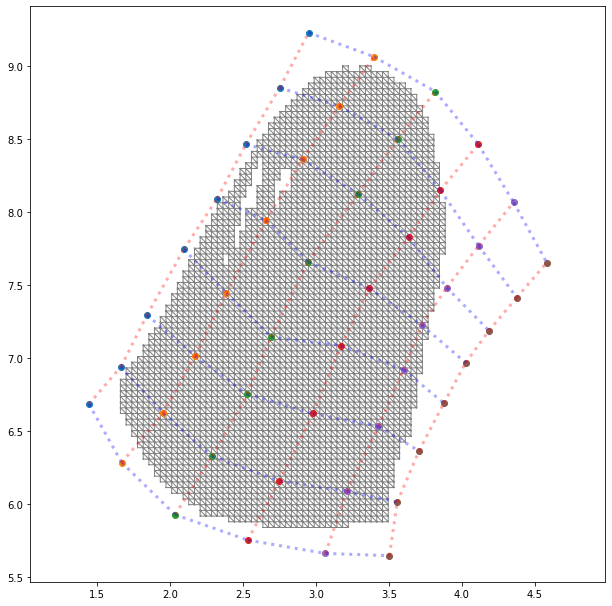

In [15]:
## visualize control points in X-space
fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim([x_min_vis,x_max_vis])
ax.set_ylim([y_min_vis,y_max_vis])

ax.triplot(x[:,0], x[:,1], tri, linewidth=1.0, c='gray')

## grid points
ax.plot(P_ix, P_jy, 'o')

if False:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        plt.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':', linewidth=3.0)

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        plt.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':', linewidth=3.0)

plt.subplots_adjust(left=-0.00025, right=0.9985, top=1.0, bottom=0.0012) ## really tight margin
plt.savefig("test.png")
plt.show()

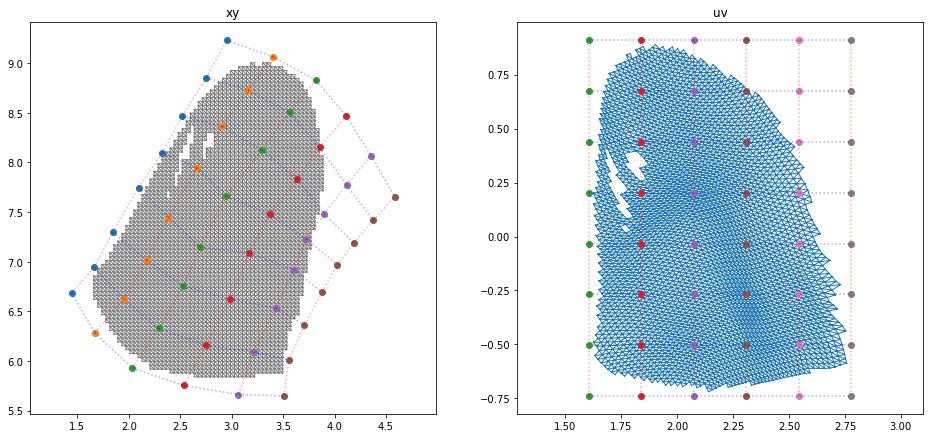

In [16]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7.2))

########################################
## XY space
########################################
ax1.set_xlim([x_min_vis,x_max_vis])
ax1.set_ylim([y_min_vis,y_max_vis])

ax1.triplot(x[:,0], x[:,1], tri, linewidth=1, color='gray')

## grid points
ax1.plot(P_ix, P_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax1.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax1.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

if False:
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

ax1.set_title('xy')

########################################
## UV space
########################################
ax2.set_xlim([u_min_vis, u_max_vis])
ax2.set_ylim([v_min_vis, v_max_vis])

ax2.triplot(u[:,0], u[:,1], tri, linewidth=1)

## grid points
ax2.plot(B_ix, B_jy, 'o')

## draw lines between grid points
for Bx in B_i:
    ax2.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    ax2.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

if False:
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

ax2.set_title('uv')

plt.show()

## Interactive User Editing

- Free-form deformation with GL interactive visualization

In [17]:
def GetUV_Grid(x00, y00, x10, y10, x01, y01, x11, y11, x, y):
    ax =  x00 - x10 - x01 + x11
    ay =  y00 - y10 - y01 + y11
    bx = -x00 + x10
    by = -y00 + y10
    cx = -x00 + x01
    cy = -y00 + y01
    dx = -x00 + x
    dy = -y00 + y
    
    A1 = (ay*bx - ax*by)
    B1 = (ay*dx - ax*dy + by*cx - bx*cy)
    C1 = (cx*dy - cy*dx)
    
    A2 = (ay*cx - ax*cy)
    B2 = (ay*dx - ax*dy + bx*cy - by*cx)
    C2 = (bx*dy - by*dx)
    
    u = (B1 + np.sqrt(B1*B1 - 4.0*A1*C1)) / (2.0 * A1) if np.abs(A1) > 1e-8 else C1/B1
    v = (B2 - np.sqrt(B2*B2 - 4.0*A2*C2)) / (2.0 * A2) if np.abs(A2) > 1e-8 else C2/B2
    
    return np.array([u,v])

def lineDet(x1, y1, x2, y2, x, y):
    a = y2-y1
    b = x2-x1
    c = -a*x1 + b*y1
    
    return a*x - b*y + c >= 0
    
def gridDet(P00_x, P00_y, P01_x, P01_y, P10_x, P10_y, P11_x, P11_y, x, y):
    b_P00_P01 = lineDet(P00_x, P00_y, P01_x, P01_y, x, y)
    b_P10_P11 = lineDet(P10_x, P10_y, P11_x, P11_y, x, y)
    b_P00_P10 = lineDet(P00_x, P00_y, P10_x, P10_y, x, y)
    b_P01_P11 = lineDet(P01_x, P01_y, P11_x, P11_y, x, y)
    
    return np.logical_and( 
        np.logical_xor(b_P00_P01, b_P10_P11),
        np.logical_xor(b_P00_P10, b_P01_P11) )

def GetIndex(u_k, v_k):
    for i in range(B_ix.shape[0]-1):
        for j in range(B_ix.shape[1]-1):
            if gridDet(B_ix[i  ][j], B_jy[i  ][j], B_ix[i  ][j+1], B_jy[i  ][j+1],
                       B_ix[i+1][j], B_jy[i+1][j], B_ix[i+1][j+1], B_jy[i+1][j+1],
                       u_k, v_k): return i,j
    print(u_k, v_k)
    return -1,-1

def GetWeight(x_k, y_k, i,j):
    x00 = B_ix[i  ][j  ]
    y00 = B_jy[i  ][j  ]
    x10 = B_ix[i  ][j+1]
    y10 = B_jy[i  ][j+1]
    x01 = B_ix[i+1][j  ]
    y01 = B_jy[i+1][j  ]
    x11 = B_ix[i+1][j+1]
    y11 = B_jy[i+1][j+1]
    
    _u, _v = GetUV_Grid(x00, y00, x10, y10, x01, y01, x11, y11, x_k, y_k)
    
    return np.array([_u,_v])

def GetIndexAndWeight(x_k, y_k):
    i, j = GetIndex(x_k, y_k)
    
    w_i, w_j = GetWeight(x_k, y_k, i, j)
    
    return (j,i), (w_i,w_j)


In [18]:
## Image space Free-form deformation
def Bernstein(t):
    t1 = 1.0 - t
    
    b0 = t1*t1*t1/6.0
    b1 = ( 3.0*t*t*t - 6.0*t*t         + 4.0) / 6.0
    b2 = (-3.0*t*t*t + 3.0*t*t + 3.0*t + 1.0) / 6.0
    b3 = t*t*t/6.0
    
    return np.array([[b0, b1, b2, b3]])

def FFD(P, u, v):
    w = np.dot(Bernstein(v).T, Bernstein(u)).reshape(-1)

    newX = (w * P[:,:,0].reshape(-1)).sum()
    newY = (w * P[:,:,1].reshape(-1)).sum()
    
    return np.array([newX, newY])


In [19]:
def RecomputeFFD(u):
    new_x = u.copy()
    
    for k in range(len(new_x)):
        u_k = u[k]
        (j,i), (w_j,w_i) = GetIndexAndWeight(u_k[0], u_k[1])

        ## default grid P{y ind}{x ind}
        P11 = np.array([P_ix[i  ,j  ], P_jy[i  ,j  ]])
        P12 = np.array([P_ix[i  ,j+1], P_jy[i  ,j+1]])
        P21 = np.array([P_ix[i+1,j  ], P_jy[i+1,j  ]])
        P22 = np.array([P_ix[i+1,j+1], P_jy[i+1,j+1]])
        
        ## outside of the default grid
        P00 = np.array([P_ix[i-1,j-1], P_jy[i-1,j-1]]) if (i-1>=0) and (j-1>=0) else 2.0*P11 - P22
        P01 = np.array([P_ix[i-1,j  ], P_jy[i-1,j  ]]) if (i-1>=0) else 2.0*P11 - P21
        P02 = np.array([P_ix[i-1,j+1], P_jy[i-1,j+1]]) if (i-1>=0) else 2.0*P12 - P22
        P03 = np.array([P_ix[i-1,j+2], P_jy[i-1,j+2]]) if (i-1>=0) and (j+2< B_ix.shape[1]) else 2.0*P12 - P21

        P10 = np.array([P_ix[i  ,j-1], P_jy[i  ,j-1]]) if (j-1>=0) else 2.0*P11 - P12
        P13 = np.array([P_ix[i  ,j+2], P_jy[i  ,j+2]]) if (j+2< B_ix.shape[1]) else 2.0*P12 - P11

        P20 = np.array([P_ix[i+1,j-1], P_jy[i+1,j-1]]) if (j-1>=0) else 2.0*P21 - P22
        P23 = np.array([P_ix[i+1,j+2], P_jy[i+1,j+2]]) if (j+2< B_ix.shape[1]) else 2.0*P22 - P21

        P30 = np.array([P_ix[i+2,j-1], P_jy[i+2,j-1]]) if (i+2< B_jy.shape[0]) and (j-1>=0) else 2.0*P21 - P12
        P31 = np.array([P_ix[i+2,j  ], P_jy[i+2,j  ]]) if (i+2< B_jy.shape[0]) else 2.0*P21 - P11
        P32 = np.array([P_ix[i+2,j+1], P_jy[i+2,j+1]]) if (i+2< B_jy.shape[0]) else 2.0*P22 - P12
        P33 = np.array([P_ix[i+2,j+2], P_jy[i+2,j+2]]) if (i+2< B_jy.shape[0]) and (j+2< B_ix.shape[1]) else 2.0*P22 - P11

        ## get four free-form deformation
        P = np.array([[P00,P01,P02,P03],
                      [P10,P11,P12,P13],
                      [P20,P21,P22,P23],
                      [P30,P31,P32,P33]])
        
        new_x[k] = FFD(P, w_j, w_i)
        
    return new_x

x_ffd = RecomputeFFD(u)

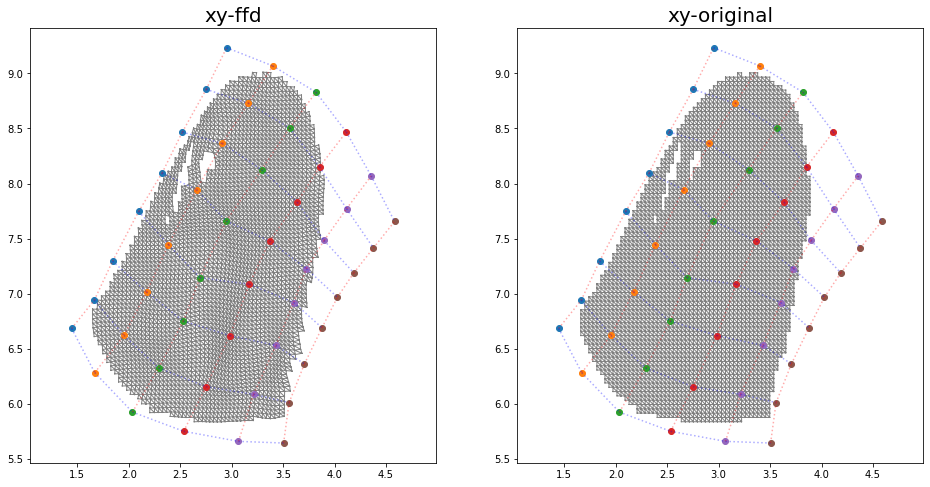

In [20]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

########################################
## XY space
########################################
ax1.set_xlim([x_min_vis,x_max_vis])
ax1.set_ylim([y_min_vis,y_max_vis])

ax1.triplot(x_ffd[:,0], x_ffd[:,1], tri, linewidth=1, color='gray')

## grid points
ax1.plot(P_ix, P_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax1.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax1.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

ax1.set_title('xy-ffd').set_fontsize(20)

########################################
## UV space
########################################
ax2.set_xlim([x_min_vis,x_max_vis])
ax2.set_ylim([y_min_vis,y_max_vis])

ax2.triplot(x[:,0], x[:,1], tri, linewidth=1, color='gray')

## grid points
ax2.plot(P_ix, P_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax2.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax2.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

ax2.set_title('xy-original').set_fontsize(20)

plt.show()

In [21]:
## gridmesh vertices
grid_X = B_ix.shape[1]*4
grid_Y = B_ix.shape[0]*4
new_u_ix, new_u_jy = np.meshgrid(np.linspace(u_min, u_max, grid_X),
                                 np.linspace(v_min, v_max, grid_Y))
new_u = np.dstack((new_u_ix, new_u_jy)).reshape(-1,2)
#print(new_u_ij.shape)

## simple triangulation for gridmesh
new_tri = []
for j in range(grid_Y-1):
    for i in range(grid_X-1):
        f00 = (i+0) + grid_X*(j+0)
        f01 = (i+1) + grid_X*(j+0)
        f10 = (i+0) + grid_X*(j+1)
        f11 = (i+1) + grid_X*(j+1)
        new_tri.append([f00, f01, f10])
        new_tri.append([f10, f01, f11])

new_tri = np.array(new_tri)

if False:
    fig, ax = plt.subplots(figsize=(8,8))

    ax.set_xlim([u_min_vis, u_max_vis])
    ax.set_ylim([v_min_vis, v_max_vis])
    #ax.plot(new_u_ij[:,0], new_u_ij[:,1], '.', color='green')
    ax.triplot(new_u[:,0], new_u[:,1], new_tri, linewidth=1, color='green')

    ax.add_patch(Rectangle((u_min, v_min), u_max-u_min, v_max-v_min, edgecolor='red', fill=False))

    plt.show()

In [22]:
## for partial update
new_x = new_u.copy() ## in advance

new_P_ij = []
new_w_ij = []

## get indices in advance
for k in range(len(new_x)):
    u_k = new_u[k]
    (j,i), (w_j,w_i) = GetIndexAndWeight(u_k[0], u_k[1])
    
    new_P_ij.append(np.array([i,j]))
    new_w_ij.append(np.array([w_i,w_j]))

new_P_ij = np.array(new_P_ij)
new_w_ij = np.array(new_w_ij)

In [23]:
def RecomputeFFD_Partial(id_i, id_j, compute_full=False):
    global new_x

    for k in range(len(new_x)):
        i,j = new_P_ij[k]
        
        ## filter based on control point id
        if ((not compute_full)
            and not (id_i-1 <= i and i <= id_i+2)
            and not (id_j-1 <= j and j <= id_j+2)) : continue
        
        w_i,w_j = new_w_ij[k]

        ## default grid P{y ind}{x ind}
        P11 = np.array([P_ix[i  ,j  ], P_jy[i  ,j  ]])
        P12 = np.array([P_ix[i  ,j+1], P_jy[i  ,j+1]])
        P21 = np.array([P_ix[i+1,j  ], P_jy[i+1,j  ]])
        P22 = np.array([P_ix[i+1,j+1], P_jy[i+1,j+1]])
        
        ## outside of the default grid
        P00 = np.array([P_ix[i-1,j-1], P_jy[i-1,j-1]]) if (i-1>=0) and (j-1>=0) else 2.0*P11 - P22
        P01 = np.array([P_ix[i-1,j  ], P_jy[i-1,j  ]]) if (i-1>=0) else 2.0*P11 - P21
        P02 = np.array([P_ix[i-1,j+1], P_jy[i-1,j+1]]) if (i-1>=0) else 2.0*P12 - P22
        P03 = np.array([P_ix[i-1,j+2], P_jy[i-1,j+2]]) if (i-1>=0) and (j+2< B_ix.shape[1]) else 2.0*P12 - P21

        P10 = np.array([P_ix[i  ,j-1], P_jy[i  ,j-1]]) if (j-1>=0) else 2.0*P11 - P12
        P13 = np.array([P_ix[i  ,j+2], P_jy[i  ,j+2]]) if (j+2< B_ix.shape[1]) else 2.0*P12 - P11

        P20 = np.array([P_ix[i+1,j-1], P_jy[i+1,j-1]]) if (j-1>=0) else 2.0*P21 - P22
        P23 = np.array([P_ix[i+1,j+2], P_jy[i+1,j+2]]) if (j+2< B_ix.shape[1]) else 2.0*P22 - P21

        P30 = np.array([P_ix[i+2,j-1], P_jy[i+2,j-1]]) if (i+2< B_jy.shape[0]) and (j-1>=0) else 2.0*P21 - P12
        P31 = np.array([P_ix[i+2,j  ], P_jy[i+2,j  ]]) if (i+2< B_jy.shape[0]) else 2.0*P21 - P11
        P32 = np.array([P_ix[i+2,j+1], P_jy[i+2,j+1]]) if (i+2< B_jy.shape[0]) else 2.0*P22 - P12
        P33 = np.array([P_ix[i+2,j+2], P_jy[i+2,j+2]]) if (i+2< B_jy.shape[0]) and (j+2< B_ix.shape[1]) else 2.0*P22 - P11

        ## get four free-form deformation
        P = np.array([[P00,P01,P02,P03],
                      [P10,P11,P12,P13],
                      [P20,P21,P22,P23],
                      [P30,P31,P32,P33]])
        
        new_x[k] = FFD(P, w_j, w_i)
        
    return None

RecomputeFFD_Partial(-1, -1, True) ## compute the initial FFD values

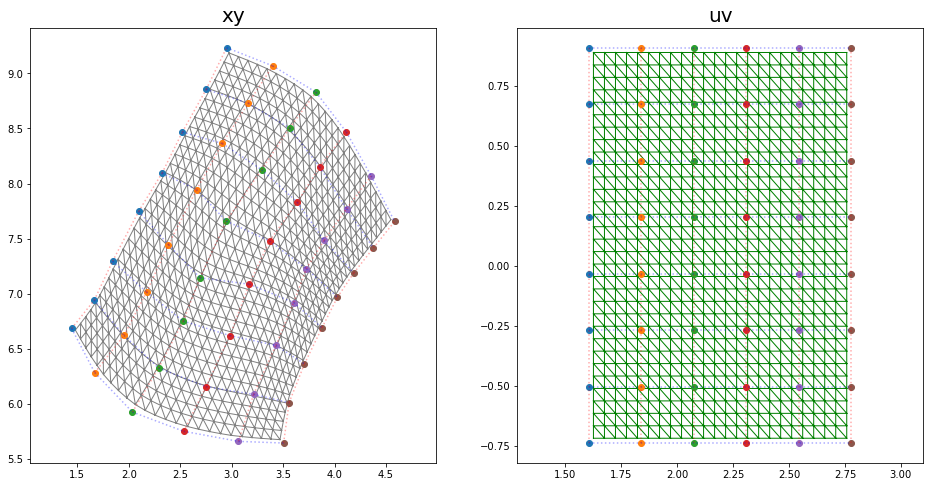

In [24]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

########################################
## Transferred by Forward FFD
########################################
ax1.set_xlim([x_min_vis,x_max_vis])
ax1.set_ylim([y_min_vis,y_max_vis])

ax1.triplot(new_x[:,0], new_x[:,1], new_tri, linewidth=1, color='gray')

## grid points
ax1.plot(P_ix, P_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax1.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax1.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

ax1.set_title('xy').set_fontsize(20)

########################################
## original mesh (for comparison)
########################################
ax2.set_xlim([u_min_vis, u_max_vis])
ax2.set_ylim([v_min_vis, v_max_vis])

ax2.triplot(new_u[:,0], new_u[:,1], new_tri, linewidth=1, color='green')

## grid points
ax2.plot(B_ix, B_jy, 'o')

## draw lines between grid points
for Bx in B_i:
    ax2.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    ax2.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

ax2.set_title('uv').set_fontsize(20)

plt.show()

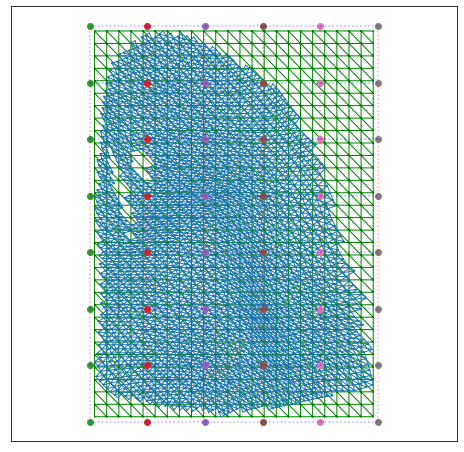

In [25]:
fig, ax2 = plt.subplots(1, 1, figsize=(8,8))

########################################
## original mesh (for comparison)
########################################
ax2.set_xlim([u_min_vis, u_max_vis])
ax2.set_ylim([v_min_vis, v_max_vis])

ax2.triplot(new_u[:,0], new_u[:,1], new_tri, linewidth=1, color='green')

ax2.triplot(u[:,0], u[:,1], tri, linewidth=1)

## grid points
ax2.plot(B_ix, B_jy, 'o')

if True:
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

## draw lines between grid points
for Bx in B_i:
    ax2.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    ax2.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

#ax2.set_title('uv').set_fontsize(20)

## really tight margin to save image
if False:
    plt.subplots_adjust(left=-0.00025, right=0.9985, top=1.0, bottom=0.0012)
    plt.savefig("test.png")

plt.show()

In [26]:
## read texture image
filename = 'data/redtartan.png'

if True:
    root=tkinter.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)

    fTyp=[('mesh file','*.png;*.jpg;*.bmp')]
    filename=tkinter.filedialog.askopenfilename(filetypes=fTyp, initialdir='./data')
    root.destroy() ## [CAUTION]

tex2D = plt.imread(filename) ## re-use matplotlib.pyplot
#plt.imshow(tex2D)

In [26]:
## load previous control points, if needed
if False:
    P_ix = np.load('./output/P_ix.npy')
    P_jy = np.load('./output/P_jy.npy')
    RecomputeFFD_Partial(-1, -1, True)

In [27]:
from OpenGL import GL
from pyopengltk import OpenGLFrame

## get texture type
tex2D_type = GL.GL_RED

if tex2D.shape[2]==3: tex2D_type = GL.GL_RGB
if tex2D.shape[2]==4: tex2D_type = GL.GL_RGBA

In [28]:
class AppGL(OpenGLFrame):

    def initgl(self):
        GL.glClearColor(0.2, 0.3, 0.5, 0.0)
        
        ########################################
        ## texture creation
        ########################################
        self.texture = GL.glGenTextures(1)
        
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_WRAP_S, GL.GL_REPEAT)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_WRAP_T, GL.GL_REPEAT)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_MIN_FILTER, GL.GL_LINEAR)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_MAG_FILTER, GL.GL_LINEAR)
        
        GL.glTexImage2D(GL.GL_TEXTURE_2D, 0, tex2D_type, 
                        tex2D.shape[1], tex2D.shape[0], 0, tex2D_type, GL.GL_FLOAT, np.ravel(tex2D))
        
    def redraw(self):
        GL.glClear(GL.GL_COLOR_BUFFER_BIT)
        
        ## set projection matrix: orthogonal camera
        GL.glMatrixMode(GL.GL_PROJECTION)
        GL.glLoadIdentity()
        GL.glOrtho(x_min_vis, x_max_vis, y_min_vis, y_max_vis, -1.0, 1.0)

        ## set camera position as identity
        GL.glMatrixMode(GL.GL_MODELVIEW)
        GL.glLoadIdentity()
        
        ## draw triangle mesh (fill) --- FFD gridmesh
        GL.glColor3d(1.0, 1.0, 1.0)
        if True:
            GL.glEnable(GL.GL_TEXTURE_2D)

            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            GL.glEnableClientState(GL.GL_VERTEX_ARRAY)
            GL.glEnableClientState(GL.GL_TEXTURE_COORD_ARRAY)
            GL.glVertexPointer(2, GL.GL_DOUBLE, 0, np.ravel(new_x) )
            GL.glTexCoordPointer(2, GL.GL_DOUBLE, 0, np.ravel(new_u) )
            GL.glDrawElements(GL.GL_TRIANGLES, len(np.ravel(new_tri)), GL.GL_UNSIGNED_INT, np.ravel(new_tri))
            GL.glDisableClientState(GL.GL_VERTEX_ARRAY)
            GL.glDisableClientState(GL.GL_TEXTURE_COORD_ARRAY)
            
            GL.glDisable(GL.GL_TEXTURE_2D)

        ## draw triangle mesh (fill) --- original mesh
        GL.glColor3d(1.0, 1.0, 1.0)
        if False:
            GL.glEnable(GL.GL_TEXTURE_2D)

            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            GL.glEnableClientState(GL.GL_VERTEX_ARRAY)
            GL.glEnableClientState(GL.GL_TEXTURE_COORD_ARRAY)
            
            GL.glVertexPointer(2, GL.GL_DOUBLE, 0, np.ravel(x) )
            GL.glTexCoordPointer(2, GL.GL_DOUBLE, 0, np.ravel(u) )
            GL.glDrawElements(GL.GL_TRIANGLES, len(tri)*3, GL.GL_UNSIGNED_INT, np.ravel(tri))
            
            GL.glDisableClientState(GL.GL_VERTEX_ARRAY)
            GL.glDisableClientState(GL.GL_TEXTURE_COORD_ARRAY)
            
            GL.glDisable(GL.GL_TEXTURE_2D)

        ## draw triangle mesh (line) --- original mesh
        GL.glColor3d(0.0, 0.0, 0.0)
        if True:
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_LINE)
            GL.glEnableClientState(GL.GL_VERTEX_ARRAY);
            GL.glVertexPointer(2, GL.GL_DOUBLE, 0, np.ravel(x))
            GL.glDrawElements(GL.GL_TRIANGLES, len(tri)*3, GL.GL_UNSIGNED_INT, np.ravel(tri))
            GL.glDisableClientState(GL.GL_VERTEX_ARRAY)
        
        ## draw control points
        if True:
            GL.glPointSize(8.0)
            GL.glColor3d(0.0, 0.0, 0.0) ## cyan
            GL.glBegin(GL.GL_POINTS)
            
            for j in range(P_ix.shape[1]):
                for i in range(P_ix.shape[0]):
                    GL.glVertex3d(P_ix[i,j], P_jy[i,j], 0.0)
            GL.glEnd()
            
            ## color cycyle in matplotlib: https://stackoverflow.com/a/42091037
            colorList = [( 31,119,180), (255,127, 14), ( 44,160, 44), (214, 39, 40), (148,103,189),
                         (140, 86, 75), (227,119,194), (127,127,127), (188,189, 34), ( 23,190,207)]
            
            GL.glPointSize(4.0)
            GL.glBegin(GL.GL_POINTS)
            for j in range(P_ix.shape[1]):
                GL.glColor3d(colorList[j][0]/255.0,colorList[j][1]/255.0,colorList[j][2]/255.0)
                for i in range(P_ix.shape[0]):
                    GL.glVertex3d(P_ix[i,j], P_jy[i,j], 0.0)
            GL.glEnd()
        
        ## draw lines between control points
        if True:
            GL.glColor3d(0.0, 1.0, 1.0) ## cyan (same as point)
            GL.glBegin(GL.GL_LINES)
            
            for j in range(P_ix.shape[1]-1):
                for i in range(P_ix.shape[0]-1):
                    GL.glVertex3d(P_ix[i  ,j  ], P_jy[i  ,j  ], 0.0)
                    GL.glVertex3d(P_ix[i  ,j+1], P_jy[i  ,j+1], 0.0)
                    GL.glVertex3d(P_ix[i  ,j  ], P_jy[i  ,j  ], 0.0)
                    GL.glVertex3d(P_ix[i+1,j  ], P_jy[i+1,j  ], 0.0)
                    GL.glVertex3d(P_ix[i+1,j  ], P_jy[i+1,j  ], 0.0)
                    GL.glVertex3d(P_ix[i+1,j+1], P_jy[i+1,j+1], 0.0)
                    GL.glVertex3d(P_ix[i  ,j+1], P_jy[i  ,j+1], 0.0)
                    GL.glVertex3d(P_ix[i+1,j+1], P_jy[i+1,j+1], 0.0)

            GL.glEnd()

###############################################################################
## window (similar to GLUT/GLFW)
###############################################################################
root = tkinter.Tk()

app = AppGL(root, width=800, height=800)
app.pack(fill=tkinter.BOTH, expand=tkinter.YES)
app.animate = 1


###############################################################################
## compute projected point & get the nearest point
###############################################################################
def get3D(win_x, win_y):
    x = win_x / root.winfo_width()
    y = (root.winfo_height()-win_y) / root.winfo_height() ## [CAUTION]
    
    x = x_min_vis + x * (x_max_vis - x_min_vis)
    y = y_min_vis + y * (y_max_vis - y_min_vis)
    return x, y

def getNearestControlPoint(x,y):
    min_dist = np.inf
    min_id = (-1,-1)
    
    for j in range(P_ix.shape[1]):
        for i in range(P_ix.shape[0]):
            dx = x - P_ix[i,j]
            dy = y - P_jy[i,j]
            dist = dx*dx + dy*dy
            
            if dist < min_dist:
                min_dist = dist
                min_id = (i,j)
            
    return np.sqrt(min_dist), min_id


###############################################################################
## mouse interaction
###############################################################################
drag = False
drag_id = (-1,-1)

def motion(event):
    #print(event, end='\r')
    global drag, drag_id
    
    if drag:
        x, y = get3D(event.x, event.y)
        
        P_ix[drag_id[0],drag_id[1]] = x
        P_jy[drag_id[0],drag_id[1]] = y
        
        #RecomputeFFD()
        RecomputeFFD_Partial(drag_id[0], drag_id[1])
    
def press(event):
    #print(event, end='\r')
    global drag, drag_id
    
    if event.num == 1:
        x, y = get3D(event.x, event.y)
        
        ## pick the nearest control point ...
        min_dist, min_id = getNearestControlPoint(x,y)
        
        if min_dist < 0.3:
            #print(min_dist, min_id)
            drag = True
            drag_id = min_id
    
def release(event):
    #print(event, end='\r')
    global drag, drag_id
    
    if event.num == 1:
        drag = False
        drag_id = (-1,-1)

## register mouse callbacks to Tkinter window
root.bind('<Motion>', motion)
root.bind('<ButtonPress>', press)
root.bind('<ButtonRelease>', release)

## finally, run GL program
#app.after(100, app.printContext)
app.mainloop()

print('CLOSED')

CLOSED


## Remap to original mesh

- get the mapped triangle its relative position to get new uv for each vertex x_ffd
- export mesh file (.obj) with material (.mtl) and texture image (.png)

In [29]:
def TriangleArea(v0, v1, v2):
    a = np.array([[v0[0], v0[1], 1.0],
                  [v1[0], v1[1], 1.0],
                  [v2[0], v2[1], 1.0]])
    return 0.5 * np.abs(np.linalg.det(a))

In [30]:
import scipy.spatial as ss

u_invffd = u.copy()

print("try to remap uv ...")

start = datetime.now()

## to use k-d tree !
tree = ss.KDTree(new_x, leafsize=10)
v2f_grid = igl.vertex_triangle_adjacency(new_tri, len(new_x))

for k in range(len(u_invffd)):
    xk = x_ffd[k]
    
    ## brute-force search (not so efficient)
    """
    for _tri in new_tri:
        ## get three vertices of this triangle
        v0 = new_x[_tri[0]]
        v1 = new_x[_tri[1]]
        v2 = new_x[_tri[2]]
        
        ## check the ffd vertex is inside of this triangle:
        b_v0_v1 = lineDet(v1[0], v1[1], v0[0], v0[1], xk[0], xk[1])
        b_v1_v2 = lineDet(v2[0], v2[1], v1[0], v1[1], xk[0], xk[1])
        b_v2_v0 = lineDet(v0[0], v0[1], v2[0], v2[1], xk[0], xk[1])
        
        ## compute new uv based on the barycentric coordinate
        if (b_v0_v1 and b_v1_v2 and b_v2_v0):
            w = TriangleArea(v0, v1, v2)
            w0 = TriangleArea(xk, v1, v2) / w
            w1 = TriangleArea(v0, xk, v2) / w
            w2 = TriangleArea(v0, v1, xk) / w
            u_invffd[k] = w0*new_u[_tri[0]] + w1*new_u[_tri[1]] + w2*new_u[_tri[2]]
            break
    """
    
    errorneous = True
    _, vindices = tree.query(xk, 3)
    
    for vidx in vindices:
        for what in range(v2f_grid[1][vidx], v2f_grid[1][vidx+1]):
            fidx = v2f_grid[0][what]
            
            ## get three vertices of this triangle
            v0 = new_x[new_tri[fidx][0]]
            v1 = new_x[new_tri[fidx][1]]
            v2 = new_x[new_tri[fidx][2]]
            
            ## check the ffd vertex is inside of this triangle:
            b_v0_v1 = lineDet(v1[0], v1[1], v0[0], v0[1], xk[0], xk[1])
            b_v1_v2 = lineDet(v2[0], v2[1], v1[0], v1[1], xk[0], xk[1])
            b_v2_v0 = lineDet(v0[0], v0[1], v2[0], v2[1], xk[0], xk[1])
            
            ## compute new uv based on the barycentric coordinate
            if (b_v0_v1 and b_v1_v2 and b_v2_v0):
                w = TriangleArea(v0, v1, v2)
                w0 = TriangleArea(xk, v1, v2) / w
                w1 = TriangleArea(v0, xk, v2) / w
                w2 = TriangleArea(v0, v1, xk) / w
                u_invffd[k] = w0*new_u[new_tri[fidx][0]] + w1*new_u[new_tri[fidx][1]] + w2*new_u[new_tri[fidx][2]]
                errorneous = False
                break
    
    print("{0:4d} / {1:4d}".format(k, len(u_invffd)),end='\r')

    if errorneous:
        print("{0:4d} / {1:4d} - ERROR...".format(k, len(u_invffd)),end='\n')
    
end = datetime.now()

print("{0:4d} / {0:4d} - DONE".format(len(u_invffd)))

print("elapsed time: {0} [sec]".format( (end-start).total_seconds() ))

try to remap uv ...
3308 / 3308 - DONE
elapsed time: 1.174854 [sec]


In [31]:
import os.path

filename = 'data/test.obj'

if True:
    root=tkinter.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)

    fTyp=[('mesh file','*.obj')]
    filename = tkinter.filedialog.asksaveasfilename(filetypes=fTyp, title='Save mesh file', initialdir='./output', defaultextension="*.obj")
    root.destroy() ## [CAUTION]

## export the final mesh as obj file with uv values
with open(filename, 'w') as f:
    f.write('mtllib ' + os.path.splitext(os.path.basename(filename))[0]+'.mtl\n')

    for _v in x_ffd:
        f.write('v {0} {1} 0\n'.format(_v[0], _v[1]))
    
    for _vt in u_invffd:
        f.write('vt {0} {1}\n'.format(_vt[0], _vt[1]))

    for _tri in tri:
        f.write('f {0}/{0} {1}/{1} {2}/{2}\n'.format(_tri[0]+1, _tri[1]+1, _tri[2]+1))

## export material file
with open(os.path.splitext(filename)[0]+'.mtl', 'w') as f:
    f.write('map_Kd ' + os.path.splitext(os.path.basename(filename))[0]+'.png\n')

## export texture image
plt.imsave(os.path.splitext(filename)[0]+'.png', tex2D)

In [32]:
## save control points
if False:
    np.save('./output/P_ix.npy', P_ix)
    np.save('./output/P_jy.npy', P_jy)

In [33]:
class AppGL2(OpenGLFrame):

    def initgl(self):
        GL.glClearColor(0.5, 0.5, 0.5, 0.0)
        
        ########################################
        ## texture creation
        ########################################
        self.texture = GL.glGenTextures(1)
        
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_WRAP_S, GL.GL_REPEAT)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_WRAP_T, GL.GL_REPEAT)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_MIN_FILTER, GL.GL_LINEAR)
        GL.glTexParameteri(GL.GL_TEXTURE_2D, GL.GL_TEXTURE_MAG_FILTER, GL.GL_LINEAR)
        
        GL.glTexImage2D(GL.GL_TEXTURE_2D, 0, tex2D_type, 
                        tex2D.shape[1], tex2D.shape[0], 0, tex2D_type, GL.GL_FLOAT, np.ravel(tex2D))
        
    def redraw(self):
        GL.glClear(GL.GL_COLOR_BUFFER_BIT)
        
        ## set projection matrix: orthogonal camera
        GL.glMatrixMode(GL.GL_PROJECTION)
        GL.glLoadIdentity()
        GL.glOrtho(u_min_vis, u_max_vis, v_min_vis, v_max_vis, -1.0, 1.0)

        ## set camera position as identity
        GL.glMatrixMode(GL.GL_MODELVIEW)
        GL.glLoadIdentity()
        
        ## triangle UV
        GL.glColor3d(1.0, 1.0, 1.0)
        if False:
            GL.glEnable(GL.GL_TEXTURE_2D)
            
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            
            GL.glBegin(GL.GL_QUADS)
            GL.glVertex2f(u_min_vis, v_min_vis)
            GL.glTexCoord2f(u_min_vis, v_min_vis)
            
            GL.glVertex2f(u_max_vis, v_min_vis)
            GL.glTexCoord2f(u_max_vis, v_min_vis)
            
            GL.glVertex2f(u_max_vis, v_max_vis)
            GL.glTexCoord2f(u_max_vis, v_max_vis)
            
            GL.glVertex2f(u_min_vis, v_max_vis)
            GL.glTexCoord2f(u_min_vis, v_max_vis)
            GL.glEnd()
            
            GL.glDisable(GL.GL_TEXTURE_2D)
        
        ## draw triangle mesh (fill) --- FFD gridmesh
        GL.glColor3d(1.0, 1.0, 1.0)
        if True:
            GL.glEnable(GL.GL_TEXTURE_2D)

            GL.glPolygonMode(GL.GL_FRONT, GL.GL_FILL)
            GL.glEnableClientState(GL.GL_VERTEX_ARRAY)
            GL.glEnableClientState(GL.GL_TEXTURE_COORD_ARRAY)
            GL.glVertexPointer(2, GL.GL_DOUBLE, 0, np.ravel(u_invffd) )
            GL.glTexCoordPointer(2, GL.GL_DOUBLE, 0, np.ravel(u_invffd) )
            GL.glDrawElements(GL.GL_TRIANGLES, len(np.ravel(tri)), GL.GL_UNSIGNED_INT, np.ravel(tri))
            GL.glDisableClientState(GL.GL_VERTEX_ARRAY)
            GL.glDisableClientState(GL.GL_TEXTURE_COORD_ARRAY)
            
            GL.glDisable(GL.GL_TEXTURE_2D)

        ## draw triangle mesh (line) --- original mesh
        GL.glColor3d(0.0, 0.0, 0.0)
        if True:
            GL.glPolygonMode(GL.GL_FRONT, GL.GL_LINE)
            GL.glEnableClientState(GL.GL_VERTEX_ARRAY);
            GL.glVertexPointer(2, GL.GL_DOUBLE, 0, np.ravel(u_invffd))
            GL.glDrawElements(GL.GL_TRIANGLES, len(tri)*3, GL.GL_UNSIGNED_INT, np.ravel(tri))
            GL.glDisableClientState(GL.GL_VERTEX_ARRAY)
        
        ## draw control points
        if True:
            GL.glPointSize(8.0)
            GL.glColor3d(0.0, 0.0, 0.0) ## cyan
            GL.glBegin(GL.GL_POINTS)
            
            for j in range(B_ix.shape[1]):
                for i in range(B_ix.shape[0]):
                    GL.glVertex3d(B_ix[i,j], B_jy[i,j], 0.0)
            GL.glEnd()
            
            ## color cycyle in matplotlib: https://stackoverflow.com/a/42091037
            colorList = [( 31,119,180), (255,127, 14), ( 44,160, 44), (214, 39, 40), (148,103,189),
                         (140, 86, 75), (227,119,194), (127,127,127), (188,189, 34), ( 23,190,207)]
            
            GL.glPointSize(4.0)
            GL.glBegin(GL.GL_POINTS)
            for j in range(B_ix.shape[1]):
                GL.glColor3d(colorList[j][0]/255.0,colorList[j][1]/255.0,colorList[j][2]/255.0)
                for i in range(B_ix.shape[0]):
                    GL.glVertex3d(B_ix[i,j], B_jy[i,j], 0.0)
            GL.glEnd()
        
        ## draw lines between control points
        if True:
            GL.glColor3d(0.0, 1.0, 1.0) ## cyan (same as point)
            GL.glBegin(GL.GL_LINES)
            
            for j in range(B_ix.shape[1]-1):
                for i in range(B_ix.shape[0]-1):
                    GL.glVertex3d(B_ix[i  ,j  ], B_jy[i  ,j  ], 0.0)
                    GL.glVertex3d(B_ix[i  ,j+1], B_jy[i  ,j+1], 0.0)
                    GL.glVertex3d(B_ix[i  ,j  ], B_jy[i  ,j  ], 0.0)
                    GL.glVertex3d(B_ix[i+1,j  ], B_jy[i+1,j  ], 0.0)
                    GL.glVertex3d(B_ix[i+1,j  ], B_jy[i+1,j  ], 0.0)
                    GL.glVertex3d(B_ix[i+1,j+1], B_jy[i+1,j+1], 0.0)
                    GL.glVertex3d(B_ix[i  ,j+1], B_jy[i  ,j+1], 0.0)
                    GL.glVertex3d(B_ix[i+1,j+1], B_jy[i+1,j+1], 0.0)

            GL.glEnd()
        

###############################################################################
## window (similar to GLUT/GLFW)
###############################################################################
root = tkinter.Tk()

app = AppGL2(root, width=800, height=800)
app.pack(fill=tkinter.BOTH, expand=tkinter.YES)
app.animate = 1

## finally, run GL program
#app.after(100, app.printContext)
app.mainloop()

print('CLOSED')

CLOSED


(end)